# 1. TorchAudio를 이용한 음성파일 처리

## Python Audio Manipulation Packages
### Torchaudio
<img src="https://github.com/pytorch/audio/raw/main/docs/source/_static/img/logo.png" height=120>

The aim of torchaudio is to apply PyTorch to the audio domain. 


# [Library]
- `torch` : Deep learning 라이브러리, 간편하게 모델을 설계하고 학습 가능(PyTorch)
- `torchaudio` : torch tensor형식으로 오디오를 다룰 수 있는 라이브러리
- `pandas` : dataframe, csv, excel - table 데이터를 다루는 라이브러리
- `matplotlib` : 시각화용 라이브러리 
- `IPython.display` : IPython 위젯을 사용할 수 있는 라이브러리
- `pathlib` : 경로 관련 라이브러리, 파일의 경로를 쉽게 사용가능

In [1]:
import torch
import torchaudio     
import torchaudio.transforms as T
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path

In [2]:
%matplotlib inline

# [Load Audio File]
## Data : free-spoken-digit-dataset

음성 버전의 MNIST dataset

https://github.com/Jakobovski/free-spoken-digit-dataset

<img src="https://drive.google.com/uc?id=1yEjXMS5-KTrYriyPhrSaJqeneBTStao_">

### Current status
- 6 speakers
- 3,000 recordings (50 of each digit per speaker)
- English pronunciations
### Organization
Files are named in the following format: `{digitLabel}_{speakerName}_{index}.wav` Example: 7_jackson_32.wav

### Usage
The test set officially consists of the first 10% of the recordings. Recordings numbered 0-4 (inclusive) are in the test and 5-49 are in the training set.

In [3]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [4]:
# check dir
!ls

0_tutorial.ipynb	     2_MLP.ipynb		README.md
1_audio_file_handling.ipynb  free-spoken-digit-dataset


In [5]:
# get list of audio file path
!ls free-spoken-digit-dataset/


acquire_data  metadata.py	    README.md	upload_to_hub.py
__init__.py   pip_requirements.txt  recordings	utils


In [6]:
audio_dir = Path("./free-spoken-digit-dataset/recordings")
audios = list(audio_dir.rglob("*.wav"))

In [7]:
# show audios
audios[:10]


[PosixPath('free-spoken-digit-dataset/recordings/3_theo_36.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/6_nicolas_38.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/6_theo_33.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/1_jackson_45.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/9_jackson_26.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/9_nicolas_42.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/9_yweweler_17.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/8_yweweler_15.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/0_lucas_16.wav'),
 PosixPath('free-spoken-digit-dataset/recordings/4_jackson_48.wav')]

In [8]:
# show audio sample name
print(audios[0])
print(audios[0].name)
print(audios[0].stem)


free-spoken-digit-dataset/recordings/3_theo_36.wav
3_theo_36.wav
3_theo_36


# [Check Audio File]

## `ipd.Audio` 로 wav 파일 확인

In [9]:
??ipd.Audio

Init signature:
ipd.Audio(
    data=None,
    filename=None,
    url=None,
    embed=None,
    rate=None,
    autoplay=False,
    normalize=True,
    *,
    element_id=None,
)
Source:        
class Audio(DisplayObject):
    """Create an audio object.

    When this object is returned by an input cell or passed to the
    display function, it will result in Audio controls being displayed
    in the frontend (only works in the notebook).

    Parameters
    ----------
    data : numpy array, list, unicode, str or bytes
        Can be one of

          * Numpy 1d array containing the desired waveform (mono)
          * Numpy 2d array containing waveforms for each channel.
            Shape=(NCHAN, NSAMPLES). For the standard channel order, see
            http://msdn.microsoft.com/en-us/library/windows/hardware/dn653308(v=vs.85).aspx
          * List of float or integer representing the waveform (mono)
          * String containing the filename
          * Bytestring containing raw PCM da

In [10]:
# check audio sample with ipd.Audio
print(audios[3])
ipd.Audio(str(audios[3]))


free-spoken-digit-dataset/recordings/1_jackson_45.wav


## `torchaudio` 로 wav 파일 확인

### Audio Meta data

- `sample_rate` is the sampling rate of the audio
- `num_channels` is the number of channels
- `num_frames` is the number of frames per channel
- `bits_per_sample` is bit depth
- `encoding` is the sample coding format

In [11]:
??torchaudio.info

Signature: torchaudio.info(filepath: str, format: Optional[str] = None) -> torchaudio.backend.common.AudioMetaData
Source:   
@_mod_utils.requires_sox()
def info(
    filepath: str,
    format: Optional[str] = None,
) -> AudioMetaData:
    """Get signal information of an audio file.

    Args:
        filepath (path-like object or file-like object):
            Source of audio data. When the function is not compiled by TorchScript,
            (e.g. ``torch.jit.script``), the following types are accepted;

                  * ``path-like``: file path
                  * ``file-like``: Object with ``read(size: int) -> bytes`` method,
                    which returns byte string of at most ``size`` length.

            When the function is compiled by TorchScript, only ``str`` type is allowed.

            Note:

                  * When the input type is file-like object, this function cannot
                    get the correct length (``num_samples``) for certain formats,
            

In [12]:
# check audio sample with torchaudio
print(torchaudio.info(audios[0]))

AudioMetaData(sample_rate=8000, num_frames=2519, num_channels=1, bits_per_sample=16, encoding=PCM_S)


# [Load audio file]

## torchaudio를 이용하여 음악파일 불러오기
### Loading audio data
To load audio data, you can use `torchaudio.load()`.

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (`Tensor`) and sample rate (`int`).

By default, the resulting tensor object has `dtype=torch.float32` and its value range is` [-1.0, 1.0]`.

For the list of supported format, please refer to the torchaudio documentation.
```
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)
```

In [13]:
??torchaudio.load

Signature:
torchaudio.load(
    filepath: str,
    frame_offset: int = 0,
    num_frames: int = -1,
    normalize: bool = True,
    channels_first: bool = True,
    format: Optional[str] = None,
) -> Tuple[torch.Tensor, int]
Source:   
@_mod_utils.requires_sox()
def load(
    filepath: str,
    frame_offset: int = 0,
    num_frames: int = -1,
    normalize: bool = True,
    channels_first: bool = True,
    format: Optional[str] = None,
) -> Tuple[torch.Tensor, int]:
    """Load audio data from file.

    Note:
        This function can handle all the codecs that underlying libsox can handle,
        however it is tested on the following formats;

        * WAV, AMB

            * 32-bit floating-point
            * 32-bit signed integer
            * 24-bit signed integer
            * 16-bit signed integer
            * 8-bit unsigned integer (WAV only)

        * MP3
        * FLAC
        * OGG/VORBIS
        * OPUS
        * SPHERE
        * AMR-NB

        To load ``MP3``, ``FLAC`

In [14]:
# torchaudio.load
print(audios[0])
y, sr = torchaudio.load(audios[0])

free-spoken-digit-dataset/recordings/3_theo_36.wav


### Sampling Rate

In [15]:
# sampling rate
sr

8000

### Audio Tensor

In [16]:
# audio tensor
y

tensor([[ 0.0005, -0.0002,  0.0013,  ..., -0.0007, -0.0003, -0.0011]])

In [17]:
# audio tensor type
print(type(y))

<class 'torch.Tensor'>


### Duration

In [18]:
# audio shape, sampling rate
y.shape, sr

(torch.Size([1, 2519]), 8000)

In [19]:
# duration
y.shape[1] / sr

0.314875

`ipd.Audio`를 이용해서 `torch.Tensor` 타입의 변수를 읽고 들을 수 있다.

In [20]:
# display audio sample
ipd.display(ipd.Audio(y, rate=sr))

## `torch.Tensor`타입의 waveform의 시각화
`matplotlib.pyplot` 을 이용하여 audio sample을 시각화 가능

python의 `Slicing`을 통해 특정구간을 확대하여 확인 가능

### sine wave

In [21]:
# sin wave
data = list(torch.sin(torch.tensor(range(10))))
data

[tensor(0.),
 tensor(0.8415),
 tensor(0.9093),
 tensor(0.1411),
 tensor(-0.7568),
 tensor(-0.9589),
 tensor(-0.2794),
 tensor(0.6570),
 tensor(0.9894),
 tensor(0.4121)]

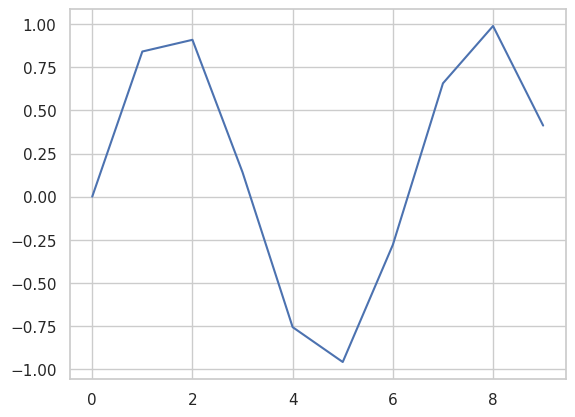

In [22]:
# plot
plt.plot(data)

### audio sample 

In [23]:
# audio tensor
y, y.shape

(tensor([[ 0.0005, -0.0002,  0.0013,  ..., -0.0007, -0.0003, -0.0011]]),
 torch.Size([1, 2519]))

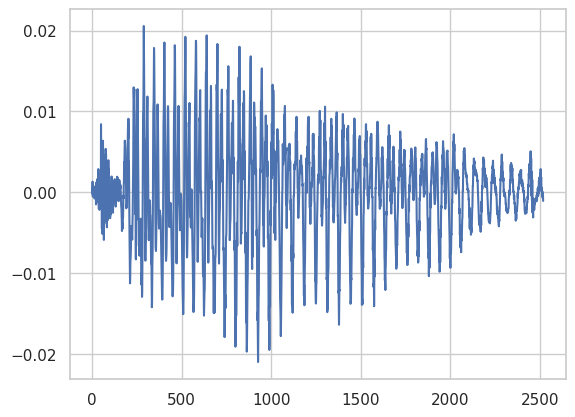

In [24]:
# plot
plt.plot(y[0])

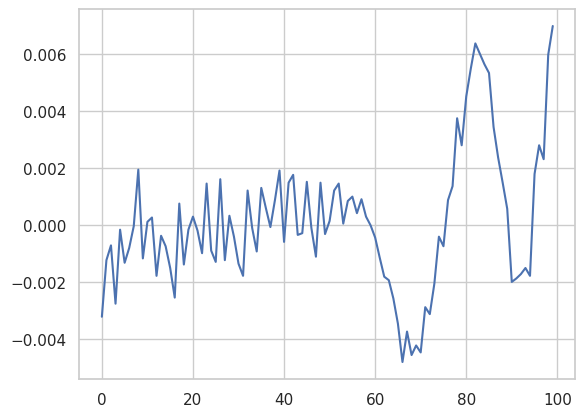

In [25]:
plt.plot(y[0][100:200])

### slicing audio sample

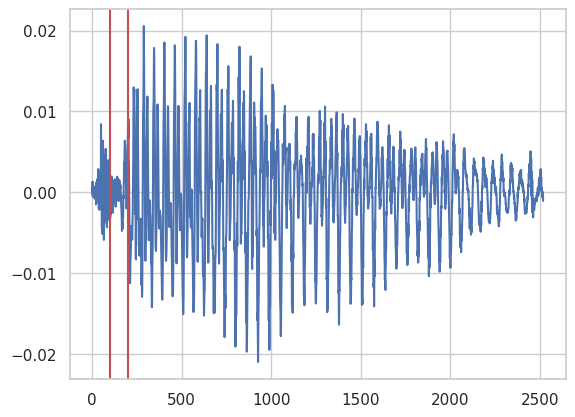

In [26]:
# slicing audio sample
plt.plot(y[0])

start, end = 100, 200
plt.axvline(start, color='r')
plt.axvline(end, color='r')

### audio sample 다양한 방식으로 확인

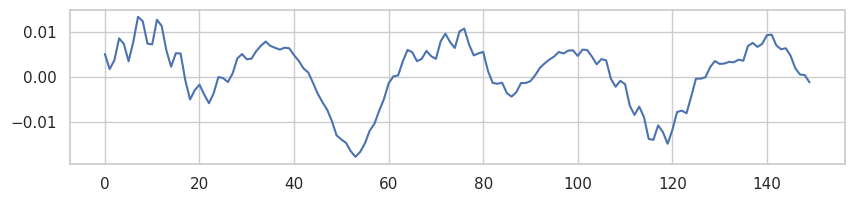

In [27]:
start,dur = 1000,150

plt.figure(figsize=(10,2),dpi=100)
plt.plot(y[0][start:start+dur])
plt.show()

<StemContainer object of 3 artists>

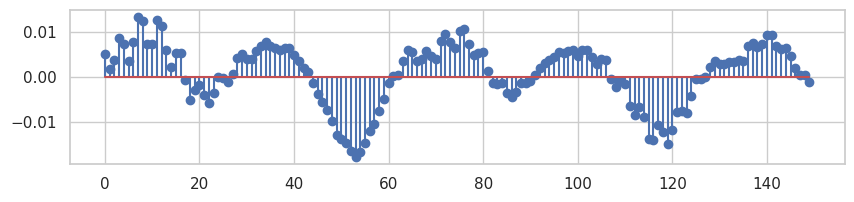

In [28]:
plt.figure(figsize=(10,2),dpi=100)
plt.stem(y[0][start:start+dur], use_line_collection=True)

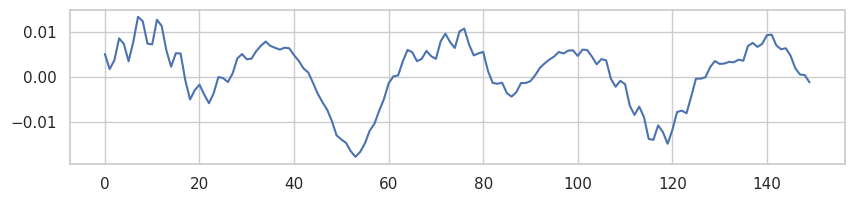

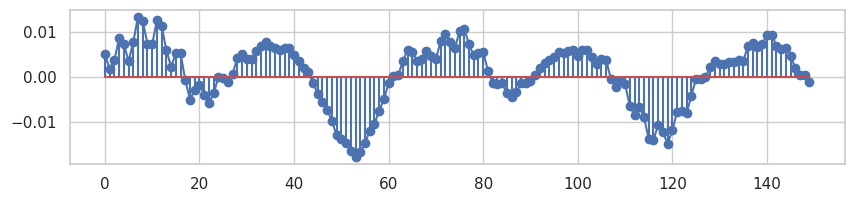

In [29]:
plt.figure(figsize=(10,2),dpi=100)
plt.plot(y[0][start:start+dur])
plt.show()

plt.figure(figsize=(10,2),dpi=100)
plt.plot(y[0][start:start+dur])
plt.stem(y[0][start:start+dur], use_line_collection=True)
plt.show()

# [Audio feature extraction] 
## Overview of audio features

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png" width=600>

STFT (DFT)

<img src="https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png?20171130134719" width=600>

<img src="https://kr.mathworks.com/help/dsp/ref/stft_output.png" width=600>

### Raw Audio sample

free-spoken-digit-dataset/recordings/3_theo_36.wav
torch.Size([1, 2519]) 8000


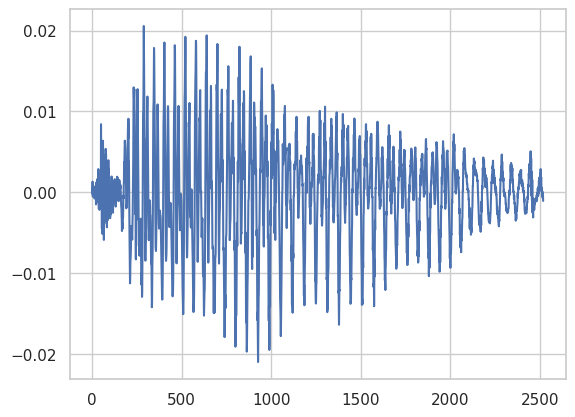

In [30]:
# load audio sample
print(audios[0])
y, sr = torchaudio.load(audios[0])
print(y.shape, sr)
plt.plot(y[0])

### Framing
- n_fft is size of FFT, creates ``n_fft // 2 + 1`` bins
- win_length is window size (e.g. 25ms = 200 (in 8kHz))
- hop_length is Length of hop between STFT windows.

In [31]:
??T.Spectrogram

Init signature:
T.Spectrogram(
    n_fft: int = 400,
    win_length: Optional[int] = None,
    hop_length: Optional[int] = None,
    pad: int = 0,
    window_fn: Callable[..., torch.Tensor] = <built-in method hann_window of type object at 0x7f0a6008a9a0>,
    power: Optional[float] = 2.0,
    normalized: bool = False,
    wkwargs: Optional[dict] = None,
    center: bool = True,
    pad_mode: str = 'reflect',
    onesided: bool = True,
    return_complex: Optional[bool] = None,
) -> None
Source:        
class Spectrogram(torch.nn.Module):
    r"""Create a spectrogram from a audio signal.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        n_fft (int, optional): Size of FFT, creates ``n_fft // 2 + 1`` bins. (Default: ``400``)
        win_length (int or None, optional): Window size. (Default: ``n_fft``)
        hop_length (int or None, optional): Length of hop between STFT windows. (Default: ``win_length // 2``)
        pad (int, optional): Two sided pa

In [32]:
# n_fft, win_length, hop_length
n_fft = 256
win_length = n_fft
hop_length = win_length//2

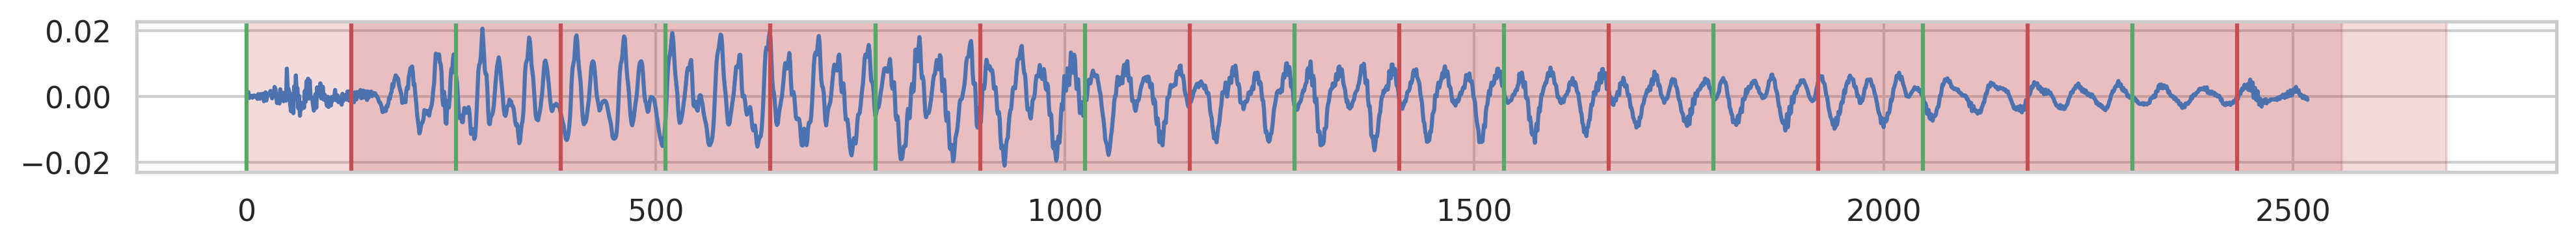

In [33]:
# framing
start, dur = 0, y.shape[1]
plt.figure(figsize=(16,1), dpi=300)
plt.plot(y[0][start:start+dur])

i=0
for x in range(start, dur, hop_length):
  i+=1
  c='r' if i%2==0 else 'g'
  plt.axvline(x, color=c)
  plt.axvspan(x, x+win_length, color='r', alpha=0.2)

### Windowing
- 각각의 프레임에 특정 함수를 적용해 경계를 스무딩하는 기법
- 단순하게 자른 프레임의 양끝에서는 신호가 존재하다가 없어지는 상황 발생. -> 해당 프레임에 푸리에 변환을 실시하게 되면 불필요한 고주파 성분이 남게되는 문제 발생

In [34]:
# hann_window
torch.hann_window(400)

tensor([0.0000e+00, 6.1691e-05, 2.4673e-04, 5.5507e-04, 9.8664e-04, 1.5413e-03,
        2.2190e-03, 3.0195e-03, 3.9426e-03, 4.9882e-03, 6.1558e-03, 7.4453e-03,
        8.8564e-03, 1.0389e-02, 1.2042e-02, 1.3815e-02, 1.5708e-02, 1.7721e-02,
        1.9853e-02, 2.2103e-02, 2.4472e-02, 2.6957e-02, 2.9560e-02, 3.2278e-02,
        3.5112e-02, 3.8060e-02, 4.1123e-02, 4.4298e-02, 4.7586e-02, 5.0986e-02,
        5.4497e-02, 5.8117e-02, 6.1847e-02, 6.5684e-02, 6.9629e-02, 7.3680e-02,
        7.7836e-02, 8.2096e-02, 8.6460e-02, 9.0925e-02, 9.5491e-02, 1.0016e-01,
        1.0492e-01, 1.0978e-01, 1.1474e-01, 1.1980e-01, 1.2494e-01, 1.3018e-01,
        1.3552e-01, 1.4094e-01, 1.4645e-01, 1.5204e-01, 1.5773e-01, 1.6349e-01,
        1.6934e-01, 1.7528e-01, 1.8129e-01, 1.8738e-01, 1.9355e-01, 1.9979e-01,
        2.0611e-01, 2.1250e-01, 2.1896e-01, 2.2549e-01, 2.3209e-01, 2.3875e-01,
        2.4548e-01, 2.5227e-01, 2.5912e-01, 2.6604e-01, 2.7300e-01, 2.8003e-01,
        2.8711e-01, 2.9424e-01, 3.0143e-

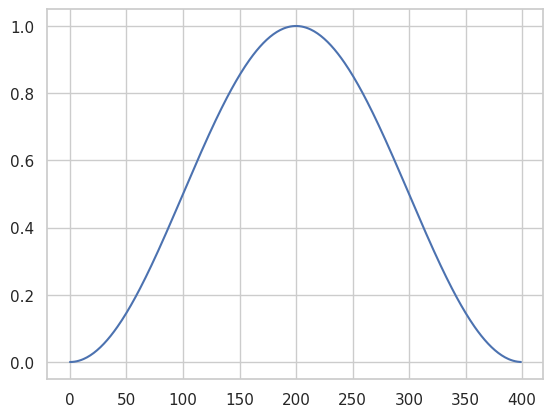

In [35]:
# show hann_window 
plt.plot(torch.hann_window(400))

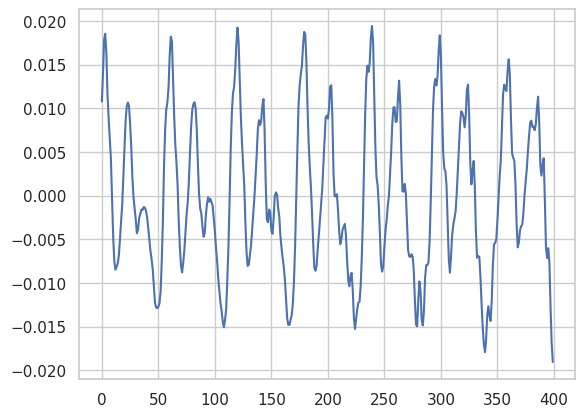

In [36]:
# sliced sample
sliced_sample = y[0][400:800]
plt.plot(sliced_sample)

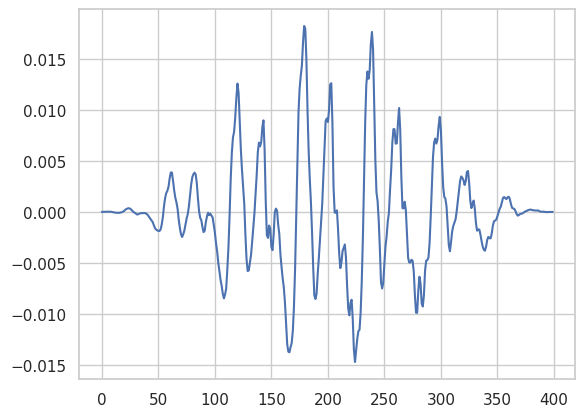

In [37]:
# apply hann_window
plt.plot(sliced_sample * torch.hann_window(400))

### Spectrogram
- x축은 시간(Time), y축은 주파수(Frequency), z축은 진폭(Amplitude)

In [38]:
# spectrogram converter
spec_converter = T.Spectrogram(n_fft=n_fft,
                               win_length=win_length,
                               hop_length=hop_length)
spec = spec_converter(y)

In [39]:
# spectrogram shape
spec.shape

torch.Size([1, 129, 20])

`torch.Size([1, 129, 20])`

1 : batch size or channel

129 : n_fft // 2 +1 (n_fft = 256)

23 : ceil(len(y) /hop_length)

In [40]:
# spectrogram shape check
import math

print(len(y[0]))
print(len(y[0])/hop_length)
print(math.ceil(len(y[0])/hop_length))

2519
19.6796875
20


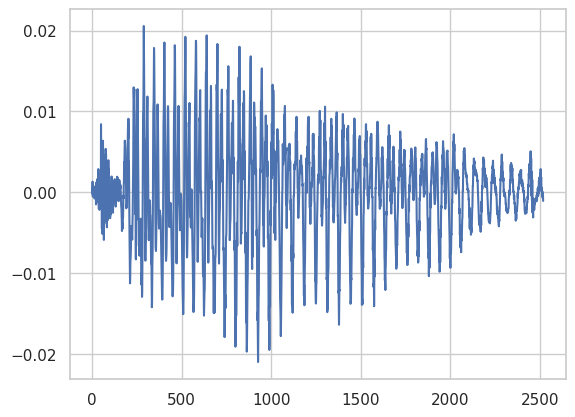

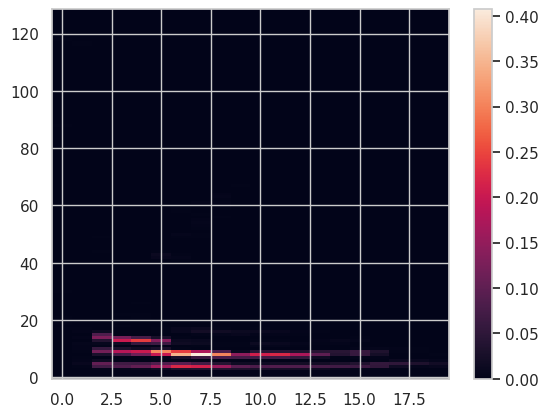

In [41]:
# show spectorgram
# spec, spec.shape
plt.plot(y[0])
plt.show()

plt.imshow(spec[0], origin="lower", aspect='auto', interpolation='nearest')
plt.colorbar()

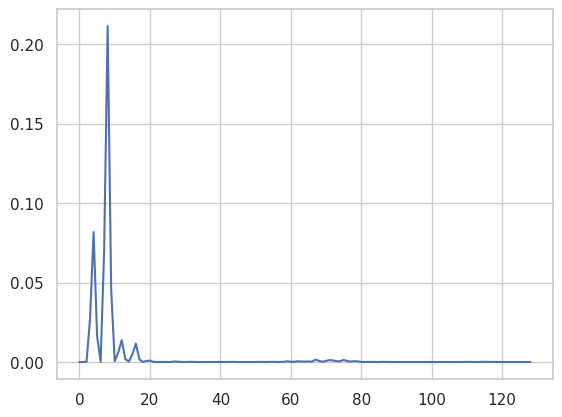

In [42]:
# Spec by time frame
plt.plot(spec[0,:,10])
plt.show()

### AmplitudeToDB

In [43]:
# db converter
db_converter = T.AmplitudeToDB()

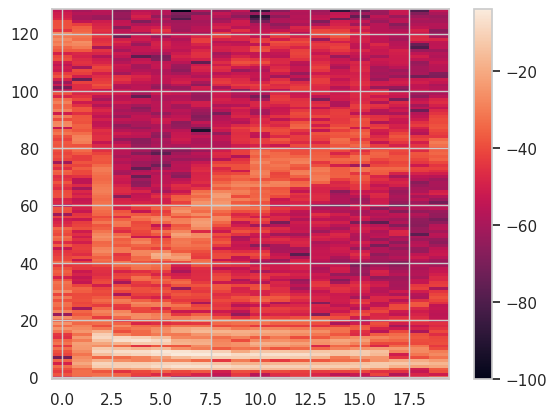

In [44]:
# show db_spec
db_spec = db_converter(spec)
plt.imshow(db_spec[0],origin="lower", aspect='auto', interpolation='nearest')
plt.colorbar()

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])
<function yticks at 0x7f0a97a43790>


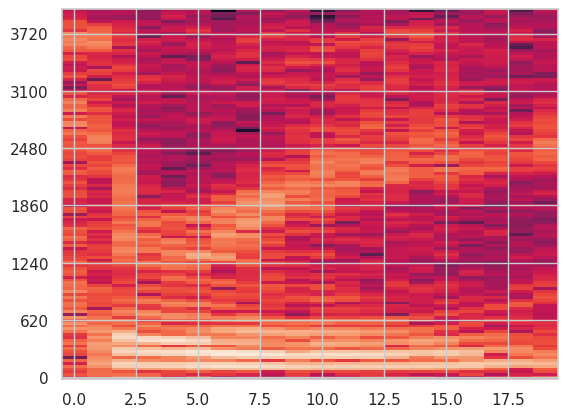

In [45]:
# Amplitude, DB relation
db_spec = db_converter(spec)
plt.imshow(db_spec[0],origin="lower", aspect='auto', interpolation='nearest')

ax =plt.gca()
print(plt.yticks())
prev_yticks = plt.yticks()[0][1:-1]
yticks_label=[int(hz/129*4000) for hz in prev_yticks]
plt.yticks(ticks = prev_yticks, labels = yticks_label)
print(plt.yticks)
plt.show()


### Mel-Spectrogram

In [46]:
??T.MelScale

Init signature:
T.MelScale(
    n_mels: int = 128,
    sample_rate: int = 16000,
    f_min: float = 0.0,
    f_max: Optional[float] = None,
    n_stft: int = 201,
    norm: Optional[str] = None,
    mel_scale: str = 'htk',
) -> None
Source:        
class MelScale(torch.nn.Module):
    r"""Turn a normal STFT into a mel frequency STFT with triangular filter banks.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        n_mels (int, optional): Number of mel filterbanks. (Default: ``128``)
        sample_rate (int, optional): Sample rate of audio signal. (Default: ``16000``)
        f_min (float, optional): Minimum frequency. (Default: ``0.``)
        f_max (float or None, optional): Maximum frequency. (Default: ``sample_rate // 2``)
        n_stft (int, optional): Number of bins in STFT. See ``n_fft`` in :class:`Spectrogram`. (Default: ``201``)
        norm (str or None, optional): If ``'slaney'``, divide the triangular mel weights by the width of the mel b

In [47]:
# define n_mels, sample_rate, f_min, f_max, n_stft


In [48]:
# define mel Scale
mel_scale = T.MelScale(n_mels=64, sample_rate=8000, f_min=20, f_max=4000, n_stft=129)

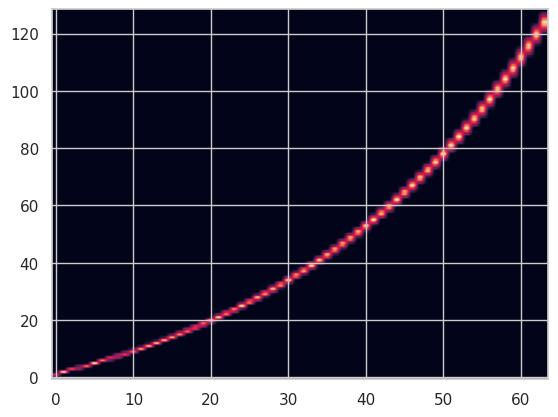

In [49]:
# show mel Scale filterbank
plt.imshow(mel_scale.fb, aspect='auto', origin='lower')

In [50]:
# define torchaudio.functional.melscale_fbanks
fb = torchaudio.functional.melscale_fbanks(n_freqs=129,
                                          f_min=20,
                                          f_max=4000,
                                          n_mels=64,
                                          sample_rate=8000)
fb.shape

torch.Size([129, 64])

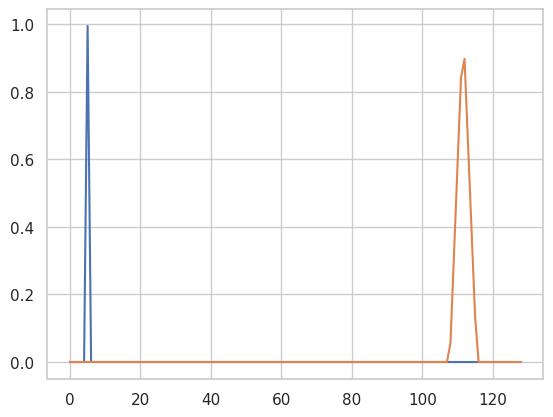

In [51]:
# filterbank low, high frequency
plt.plot(fb.T[5]) # low frequency
plt.plot(fb.T[60]) # high frequency

In [52]:
# define mel_converter
mel_converter=T.MelSpectrogram(sample_rate=8000,
                               n_mels=64,
                               n_fft=256,
                               hop_length=n_fft//2)

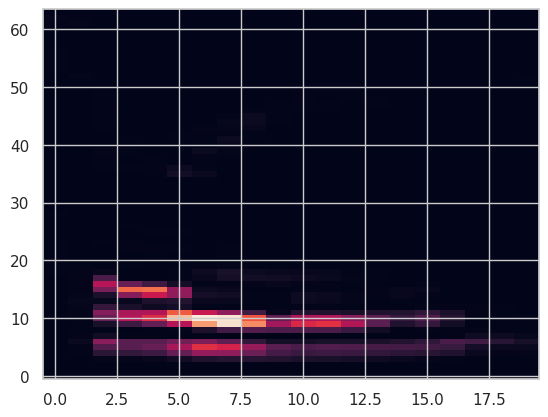

In [53]:
# mel_spec
mel_spec=mel_converter(y)
plt.imshow(mel_spec[0], aspect='auto', interpolation='nearest',origin='lower')

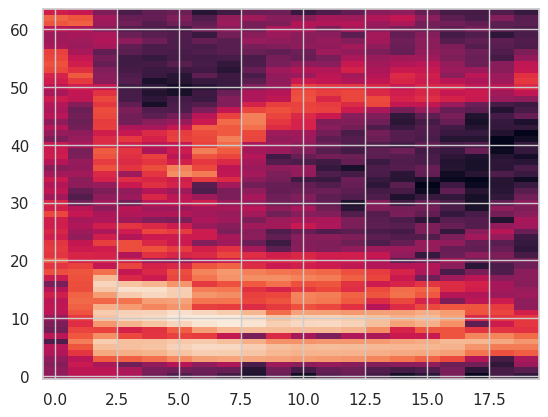

In [54]:
# mel_spec -> db_converter
mel_spec = db_converter(mel_spec)
plt.imshow(mel_spec[0], aspect='auto', interpolation='nearest',origin='lower')

### MFCC
- mel-spectrogram에 log및 IDCT(Inverse Discrete Cosine Transform)을 수행해 변수 간 상관관계를 해결
- MFCCs는 구축 과정에서 버리는 정보가 많아 최근 딥러닝 기반 모델에서는 멜 스펙트럼 혹은 로그 멜 스펙트럼을 많이 사용

In [55]:
??T.MFCC

Init signature:
T.MFCC(
    sample_rate: int = 16000,
    n_mfcc: int = 40,
    dct_type: int = 2,
    norm: str = 'ortho',
    log_mels: bool = False,
    melkwargs: Optional[dict] = None,
) -> None
Source:        
class MFCC(torch.nn.Module):
    r"""Create the Mel-frequency cepstrum coefficients from an audio signal.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    By default, this calculates the MFCC on the DB-scaled Mel spectrogram.
    This is not the textbook implementation, but is implemented here to
    give consistency with librosa.

    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip.

    Args:
        sample_rate (int, optional): Sample rate of audio signal. (Default: ``16000``)
        n_mfcc (int, optional): Number of mfc coefficients to retain. (Default: ``40``)
        dct_type (int, optional): type of DCT (discrete cosine trans

In [56]:
# define melkwargs, mfcc_converter
melkwargs={"n_fft":256,
           "n_mels":64,
           "hop_length":256//2,
           "mel_scale":"htk"
  }
mfcc_converter=T.MFCC(sample_rate=8000, n_mfcc=13, melkwargs=melkwargs)

In [57]:
# mfcc converter
mfcc = mfcc_converter(y)
mfcc.shape

torch.Size([1, 13, 20])

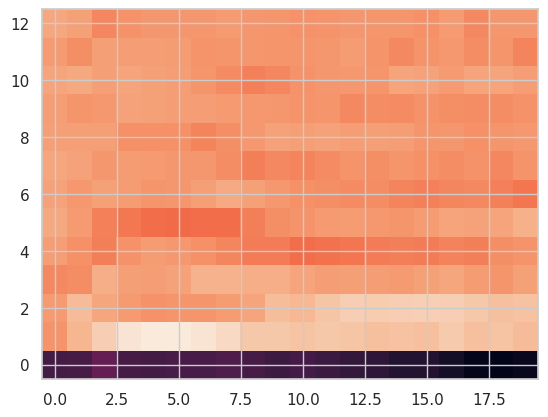

In [58]:
# show mfcc 
plt.imshow(mfcc[0], aspect='auto', interpolation='nearest',origin='lower')